## Statistical Learning and Deep Learning HW4

Load dataset.

In [1]:
# load packages
import pickle
from sklearn import preprocessing
%matplotlib inline

# load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if doscaling == 1:
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print()
print("Y_train shape = ", Y_train.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print()
print("X_test shape = ", X_test.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)

Y_train shape =  (463715,)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)

X_test shape =  (51630, 90)
Y_test shape =  (51630,)


### Q1. Oridinary Least Square (OLS)

In [2]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

ols = sm.OLS(Y_train, X_train, hasconst=True)
ols_result = ols.fit()

In [3]:
print(f'The first 5 parameters: {ols_result.params[:5]}')

The first 5 parameters: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


In [4]:
# predict
Y_predict = ols_result.predict(X_test)
print(f'The predicted Y is {Y_predict}')

The predicted Y is [-5.81070695  0.03250657  5.13960445 ... -1.39829429 -0.26047668
  0.05193056]


In [5]:
# RMSE
print(f'RMSE = {mean_squared_error(Y_test, Y_predict, squared=False)}')

RMSE = 9.510160684544402


### Q2. MLP with Four Hidden Layers

In [14]:
import numpy as np
import torch
from torch.utils import data
import os
from sklearn.metrics import mean_squared_error

print('torch version:', torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')
print(torch.cuda.current_device())

torch version: 1.7.1rc2
using cuda
0


In [15]:
# define dataset
class Dataset(data.Dataset):
    
  def __init__(self, Xnp, Ynp):
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
        
  def __len__(self):
        return self.nobs
    
  def __getitem__(self, index):     
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

In [16]:
# create dataloader
subtrain_set = Dataset(X_subtrain, Y_subtrain)    
valid_set = Dataset(X_valid, Y_valid)
test_set = Dataset(X_test, Y_test)
print('subtrain length', len(subtrain_set))
print('valid length', len(valid_set))
print('test length', len(test_set))

batch_size = 1000
subtrain_loader = data.DataLoader(subtrain_set, batch_size=batch_size)
valid_loader = data.DataLoader(valid_set, batch_size=batch_size)
test_loader = data.DataLoader(test_set, batch_size=batch_size)

subtrain length 417344
valid length 46371
test length 51630


In [17]:
# train

def RMSE(model, data_loader):
    n_obs = 0
    sse = 0
    with torch.no_grad():
        for _batch, (_inputs, _targets) in enumerate(data_loader):
            _targets = _targets.reshape((-1, 1))
            _inputs, _targets = _inputs.to(device), _targets.to(device)
            _outputs = model(_inputs)
            n_obs += _targets.shape[0]
            sse += (_targets - _outputs).pow(2).sum(0)
    return np.sqrt(sse.cpu().numpy()[0] / n_obs)

    
def train(model, optim, loss_f, max_epoch, max_step, valid_interval, weight_path, train_rmse):
    
    step_count = 0
    best_step_count = 0
    best_valid_rmse = np.inf
    all_train_rmse = []
    all_valid_rmse = []
    all_step = []

    for epoch in range(1, max_epoch+1):
        for batch, (inputs, targets) in enumerate(subtrain_loader):

            targets = targets.reshape((-1, 1))
            inputs, targets = inputs.to(device), targets.to(device)
            model.to(device)
            model.train()
            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_f(outputs, targets)
            loss.backward()
            optim.step()
            step_count += 1

            # check train/validation RMSE
            if (step_count % valid_interval == 0):

                # subtrain, validation RMSE
                if train_rmse:
                    train_rmse = RMSE(model, subtrain_loader)
                    all_train_rmse.append(train_rmse)
                valid_rmse = RMSE(model, valid_loader)
                all_valid_rmse.append(valid_rmse)
                all_step.append(step_count)

                # update weight
                if valid_rmse < best_valid_rmse:
                    best_step_count = step_count
                    best_valid_rmse = valid_rmse
                    torch.save(model, weight_path)

                # early stopping
                elif (step_count - best_step_count >= max_step):
                    print(f'early stopping, step {step_count}, validation RMSE = {valid_rmse}')
                    return all_step, all_train_rmse, all_valid_rmse
                
        print(f'Epoch {epoch}, Step {step_count}: Loss = {loss.item()}, best_valid_rmse = {best_valid_rmse}')
    return all_step, all_train_rmse, all_valid_rmse

In [18]:
# create MLP model
d_hidden = 45
d_input = subtrain_set.Xnp.shape[1]
d_output = 1

mlp = torch.nn.Sequential(
    torch.nn.Linear(d_input, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_output)
)
mlp = mlp.float()
mlp.to(device)
weight_path = './MLP45_weight'

# optimizer
lr = 0.00001
momentum = 0
weight_decay = 0
sgd_optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# loss
l2_loss = torch.nn.MSELoss(reduction='sum')

# train
all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=True)        


Epoch 1, Step 418: Loss = 34811.2265625, best_valid_rmse = 8.94553009496888
Epoch 2, Step 836: Loss = 34226.890625, best_valid_rmse = 8.71017680179246
Epoch 3, Step 1254: Loss = 34025.21875, best_valid_rmse = 8.688642361852033
Epoch 4, Step 1672: Loss = 33730.0390625, best_valid_rmse = 8.613268462556709
Epoch 5, Step 2090: Loss = 33249.12890625, best_valid_rmse = 8.603137778883292
Epoch 6, Step 2508: Loss = 33170.2578125, best_valid_rmse = 8.603137778883292
Epoch 7, Step 2926: Loss = 33348.11328125, best_valid_rmse = 8.603116472186596
Epoch 8, Step 3344: Loss = 33474.8828125, best_valid_rmse = 8.597652382522488
Epoch 9, Step 3762: Loss = 33425.3046875, best_valid_rmse = 8.596214084982677
Epoch 10, Step 4180: Loss = 33322.63671875, best_valid_rmse = 8.596214084982677
Epoch 11, Step 4598: Loss = 32925.5390625, best_valid_rmse = 8.596214084982677
Epoch 12, Step 5016: Loss = 33085.90625, best_valid_rmse = 8.58240239366959
Epoch 13, Step 5434: Loss = 32851.0703125, best_valid_rmse = 8.58240

Text(0.5, 1.0, 'H=45, Training & Validation RMSE')

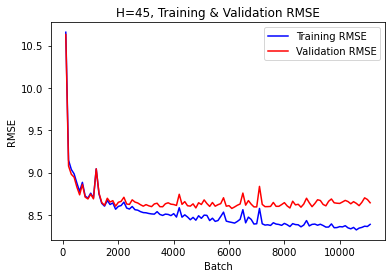

In [19]:
import matplotlib.pyplot as plt

# plot subtrain / validation RMSE
plt.plot(all_step, all_train_rmse, c='b', label='Training RMSE')
plt.plot(all_step, all_valid_rmse, c='r', label='Validation RMSE')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('H=45, Training & Validation RMSE')

From the figure above, we can see that both training RMSE and validation RMSE reduce but fluctuate through the training process. While the two curves are quite close in the beginning, training RMSE turns out to be lower than training RMSE.

In [20]:
# test RMSE
saved_mlp = torch.load(weight_path)
test_rmse = RMSE(saved_mlp, test_loader)
print(f'Test RMSE = {test_rmse}')

Test RMSE = 8.841294436539107


### Q3. H = 90, 180

In [21]:
for d_hidden in [90, 180]:
    
    d_input = subtrain_set.Xnp.shape[1]
    d_output = 1

    mlp = torch.nn.Sequential(
        torch.nn.Linear(d_input, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_output)
    )
    
    # optimizer
    lr = 0.00001
    momentum = 0
    weight_decay = 0
    sgd_optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # loss
    l2_loss = torch.nn.MSELoss(reduction='sum')
    
    mlp = mlp.float()
    mlp.to(device)
    weight_path = f'./MLP{d_hidden}_weight'
    all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=False)
    saved_mlp = torch.load(weight_path)
    test_rmse = RMSE(saved_mlp, test_loader)
    print(f'H = {d_hidden}, Test RMSE = {test_rmse}\n')

Epoch 1, Step 418: Loss = 34200.109375, best_valid_rmse = 8.901226091145327
Epoch 2, Step 836: Loss = 33780.6875, best_valid_rmse = 8.674241658673425
Epoch 3, Step 1254: Loss = 33153.56640625, best_valid_rmse = 8.638080569142724
Epoch 4, Step 1672: Loss = 32139.08203125, best_valid_rmse = 8.562022940231628
Epoch 5, Step 2090: Loss = 31482.390625, best_valid_rmse = 8.562022940231628
Epoch 6, Step 2508: Loss = 30781.51171875, best_valid_rmse = 8.562022940231628
Epoch 7, Step 2926: Loss = 30700.87109375, best_valid_rmse = 8.544342587750187
Epoch 8, Step 3344: Loss = 29986.6953125, best_valid_rmse = 8.544342587750187
Epoch 9, Step 3762: Loss = 29589.697265625, best_valid_rmse = 8.524440732241779
Epoch 10, Step 4180: Loss = 29720.140625, best_valid_rmse = 8.524440732241779
Epoch 11, Step 4598: Loss = 28300.787109375, best_valid_rmse = 8.524440732241779
Epoch 12, Step 5016: Loss = 27845.724609375, best_valid_rmse = 8.524440732241779
Epoch 13, Step 5434: Loss = 28651.138671875, best_valid_rms

(hidden dimension = 45: test RMSE = 8.841)  
**hidden dimension = 90: test RMSE = 8.824**  
**hidden dimension = 180: test RMSE = 8.901**

With test RMSE shown above, we suggest that providing 90 hidden nodes in the linear hidden layers performs the best.

### Q4 MLP with Weight Decay

In [22]:
for d_hidden in [45, 90, 180]:
    for weight_decay in [0.1, 0.2, 0.4]:
    
        d_input = subtrain_set.Xnp.shape[1]
        d_output = 1

        mlp = torch.nn.Sequential(
            torch.nn.Linear(d_input, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_output)
        )

        mlp = mlp.float()
        mlp.to(device)

        # optimizer
        lr = 0.00001
        momentum = 0
        sgd_optimizer_wd = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

        weight_path = f'./MLP{d_hidden}_{weight_decay*10}_weight'
        all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer_wd, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=False)
        saved_mlp = torch.load(weight_path)
        test_rmse = RMSE(saved_mlp, test_loader)
        print(f'H = {d_hidden} Weight decay = {weight_decay}, Test RMSE = {test_rmse}\n')

Epoch 1, Step 418: Loss = 34912.4140625, best_valid_rmse = 8.939762386907391
Epoch 2, Step 836: Loss = 34052.6328125, best_valid_rmse = 8.719163570821374
Epoch 3, Step 1254: Loss = 33766.41796875, best_valid_rmse = 8.70004401025287
Epoch 4, Step 1672: Loss = 33187.953125, best_valid_rmse = 8.622452527263516
Epoch 5, Step 2090: Loss = 32928.0703125, best_valid_rmse = 8.612548300323168
Epoch 6, Step 2508: Loss = 32510.919921875, best_valid_rmse = 8.612548300323168
Epoch 7, Step 2926: Loss = 32025.77734375, best_valid_rmse = 8.609259075554823
Epoch 8, Step 3344: Loss = 31523.86328125, best_valid_rmse = 8.579808557178483
Epoch 9, Step 3762: Loss = 31441.578125, best_valid_rmse = 8.579808557178483
Epoch 10, Step 4180: Loss = 31203.77734375, best_valid_rmse = 8.579808557178483
Epoch 11, Step 4598: Loss = 31422.44921875, best_valid_rmse = 8.579808557178483
Epoch 12, Step 5016: Loss = 31260.291015625, best_valid_rmse = 8.569624163502223
Epoch 13, Step 5434: Loss = 32024.271484375, best_valid_r

|    Test RMSE     | H=45  | H=90  | H=180 |
| ---------------- | ----- | ----- | ----- |
| weight_decay=0.1 | 8.851 | 8.886 | 8.876 |
| weight_decay=0.2 | 8.820 | 8.806 | 8.884 |
| weight_decay=0.4 | 8.794 | 8.801 | 8.868 |

From the table above, we can see that **H=45** with **weight_decay=0.4** leads to the lowest testing RMSE.

### Q5. MLP with Dropout

In [23]:
d_hidden = 90
d_input = subtrain_set.Xnp.shape[1]
d_output = 1

mlp = torch.nn.Sequential(
    torch.nn.Linear(d_input, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_output)
)
mlp = mlp.float()
mlp.to(device)
weight_path = './MLP90_drop_weight'

# optimizer
lr = 0.001
momentum = 0
weight_decay = 0
adam_optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)

# loss
l2_loss = torch.nn.MSELoss(reduction='sum')

# train
all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=adam_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=True)        


Epoch 1, Step 418: Loss = 37498.9921875, best_valid_rmse = 9.186258692961909
Epoch 2, Step 836: Loss = 36125.3359375, best_valid_rmse = 9.071526105535854
Epoch 3, Step 1254: Loss = 35325.8828125, best_valid_rmse = 9.000254585594107
Epoch 4, Step 1672: Loss = 34050.859375, best_valid_rmse = 8.95554586681681
Epoch 5, Step 2090: Loss = 34787.98828125, best_valid_rmse = 8.931380310302917
Epoch 6, Step 2508: Loss = 35317.65625, best_valid_rmse = 8.920974207522569
Epoch 7, Step 2926: Loss = 32773.45703125, best_valid_rmse = 8.90552114791495
Epoch 8, Step 3344: Loss = 34434.96875, best_valid_rmse = 8.904098673894705
Epoch 9, Step 3762: Loss = 34547.0703125, best_valid_rmse = 8.867553483159396
Epoch 10, Step 4180: Loss = 33072.8984375, best_valid_rmse = 8.865956174229254
Epoch 11, Step 4598: Loss = 34885.29296875, best_valid_rmse = 8.854683529840045
Epoch 12, Step 5016: Loss = 34875.23828125, best_valid_rmse = 8.854683529840045
Epoch 13, Step 5434: Loss = 31445.935546875, best_valid_rmse = 8.8

Text(0.5, 1.0, 'H=90 with Drop Out, Training & Validation RMSE')

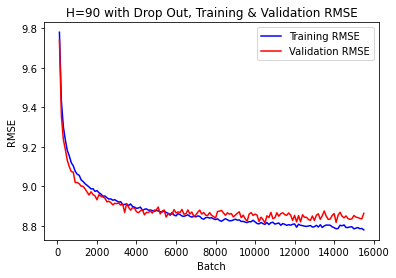

In [24]:
# plot subtrain / validation RMSE
plt.plot(all_step, all_train_rmse, c='b', label='Training RMSE')
plt.plot(all_step, all_valid_rmse, c='r', label='Validation RMSE')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('H=90 with Drop Out, Training & Validation RMSE')

From the figure above, we can see that both training RMSE and validation RMSE drop dramastically in the beginning of the training process and converges afterwards. In the first half of the training process, training RMSE is larger than validation RMSE, while in the second half, training RMSE turns out to be smaller than validation RMSE.

In [25]:
# test RMSE
saved_mlp = torch.load(weight_path)
test_rmse = RMSE(saved_mlp, test_loader)
print(f'Test RMSE = {test_rmse}')

Test RMSE = 9.029719368877945


### Q6. Explore Number of Hidden Units

In [26]:
for d_hidden in [20, 45, 180, 360]:
    
    d_input = subtrain_set.Xnp.shape[1]
    d_output = 1

    mlp = torch.nn.Sequential(
        torch.nn.Linear(d_input, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),

        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),

        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),

        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),

        torch.nn.Linear(d_hidden, d_output)
    )
    mlp = mlp.float()
    mlp.to(device)
    weight_path = './MLP{d_hidden}_drop_weight'

    # optimizer
    lr = 0.001
    momentum = 0
    weight_decay = 0
    adam_optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)

    # loss
    l2_loss = torch.nn.MSELoss(reduction='sum')

    # train
    all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=adam_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=False)        
    
    # test RMSE
    saved_mlp = torch.load(weight_path)
    test_rmse = RMSE(saved_mlp, test_loader)
    print(f'H = {d_hidden}: Test RMSE = {test_rmse}\n')

Epoch 1, Step 418: Loss = 43384.8203125, best_valid_rmse = 9.763224669693798
Epoch 2, Step 836: Loss = 38465.2734375, best_valid_rmse = 9.572969094941469
Epoch 3, Step 1254: Loss = 39023.46484375, best_valid_rmse = 9.482433656928665
Epoch 4, Step 1672: Loss = 38567.38671875, best_valid_rmse = 9.417149557373707
Epoch 5, Step 2090: Loss = 38634.7265625, best_valid_rmse = 9.413087093072491
Epoch 6, Step 2508: Loss = 36937.37890625, best_valid_rmse = 9.381767395648092
Epoch 7, Step 2926: Loss = 39024.5078125, best_valid_rmse = 9.352594674772869
Epoch 8, Step 3344: Loss = 39017.86328125, best_valid_rmse = 9.35191789831301
Epoch 9, Step 3762: Loss = 38357.61328125, best_valid_rmse = 9.35191789831301
Epoch 10, Step 4180: Loss = 35153.7421875, best_valid_rmse = 9.341722855055735
Epoch 11, Step 4598: Loss = 38768.7265625, best_valid_rmse = 9.341722855055735
Epoch 12, Step 5016: Loss = 39046.4375, best_valid_rmse = 9.331254659203784
Epoch 13, Step 5434: Loss = 37445.828125, best_valid_rmse = 9.3

H = 20, Test RMSE = 9.384  
H = 45, Test RMSE = 9.123  
H = 180, Test RMSE = 9.001  
H = 360, Test RMSE = 8.937  
The test RMSE is the lowest when H = 360.

### Q7. L2 + L1 Loss

In [28]:
def train(model, optim, loss_f1, loss_f2, loss_w, max_epoch, max_step, valid_interval, weight_path, train_rmse):
    
    step_count = 0
    best_step_count = 0
    best_valid_rmse = np.inf
    all_train_rmse = []
    all_valid_rmse = []
    all_step = []

    for epoch in range(1, max_epoch+1):
        for batch, (inputs, targets) in enumerate(subtrain_loader):

            targets = targets.reshape((-1, 1))
            inputs, targets = inputs.to(device), targets.to(device)
            model.to(device)
            model.train()
            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_w * loss_f1(outputs, targets) + (1-loss_w) * loss_f2(outputs, targets)
            loss.backward()
            optim.step()
            step_count += 1

            # check train/validation RMSE
            if (step_count % valid_interval == 0):

                # subtrain, validation RMSE
                if train_rmse:
                    train_rmse = RMSE(model, subtrain_loader)
                    all_train_rmse.append(train_rmse)
                valid_rmse = RMSE(model, valid_loader)
                all_valid_rmse.append(valid_rmse)
                all_step.append(step_count)

                # update weight
                if valid_rmse < best_valid_rmse:
                    best_step_count = step_count
                    best_valid_rmse = valid_rmse
                    torch.save(model, weight_path)

                # early stopping
                elif (step_count - best_step_count >= max_step):
                    print(f'early stopping, step {step_count}, validation RMSE = {valid_rmse}')
                    return all_step, all_train_rmse, all_valid_rmse
                
        print(f'Epoch {epoch}, Step {step_count}: Loss = {loss.item()}, best_valid_rmse = {best_valid_rmse}')
    return all_step, all_train_rmse, all_valid_rmse

In [ ]:
d_hidden = 90
d_input = subtrain_set.Xnp.shape[1]
d_output = 1

mlp = torch.nn.Sequential(
    torch.nn.Linear(d_input, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_output)
)
mlp = mlp.float()
mlp.to(device)
weight_path = './MLP90_drop_weight'

# optimizer
lr = 0.001
momentum = 0
weight_decay = 0
adam_optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)

# loss
z = 0.5
l2_loss = torch.nn.MSELoss(reduction='sum')
l1_loss = torch.nn.L1Loss(reduction='sum')

# train
all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=adam_optimizer, loss_f1=l2_loss, loss_f2=l1_loss, loss_w=z, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=True)        

Epoch 1, Step 418: Loss = 19323.93359375, best_valid_rmse = 9.200106430690298
Epoch 2, Step 836: Loss = 18682.15625, best_valid_rmse = 9.057800825567327
Epoch 3, Step 1254: Loss = 19214.287109375, best_valid_rmse = 9.01049673140981
Epoch 4, Step 1672: Loss = 17891.123046875, best_valid_rmse = 8.953730029851044
Epoch 5, Step 2090: Loss = 18084.068359375, best_valid_rmse = 8.938734696920385
Epoch 6, Step 2508: Loss = 18426.744140625, best_valid_rmse = 8.927392707710137
Epoch 7, Step 2926: Loss = 18986.419921875, best_valid_rmse = 8.915697666293697
Epoch 8, Step 3344: Loss = 18565.76953125, best_valid_rmse = 8.885472023316417
Epoch 9, Step 3762: Loss = 18317.76953125, best_valid_rmse = 8.885472023316417
Epoch 10, Step 4180: Loss = 18999.03125, best_valid_rmse = 8.876433457642245
Epoch 11, Step 4598: Loss = 18376.2890625, best_valid_rmse = 8.865604387099769
Epoch 12, Step 5016: Loss = 17357.92578125, best_valid_rmse = 8.865604387099769
Epoch 13, Step 5434: Loss = 18525.279296875, best_vali